In [1]:
# ml_pipeline.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, average_precision_score
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

scaler = MinMaxScaler()

In [2]:
# 1. Load Dataset
# Load features with editing efficiency
df = pd.read_csv("OneHot_encoded_featture_input_GATA1HbF1.csv")
df['editsStatus'] = df['editsStatus'].replace({'N': 0, 'Y': 1})
#df=df.loc[df['editsStatus']=='Y'].copy(deep=True)
#df['Freq'] = df['Freq']*df['editsStatus']

# 1. Get unique IDs
unique_ids = df['guide'].unique()

# 2. Split unique IDs
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 3. Split the data based on IDs
train_df = df[df['guide'].isin(train_ids)].reset_index(drop=True)
test_df  = df[df['guide'].isin(test_ids)].reset_index(drop=True)


# Split into features (X) and target (y)
X_train = train_df.drop(columns=['Freq',"num_edits","guide_id", "EditEff","editsStatus","guide"])
y_train = pd.DataFrame({"EditEff":train_df["editsStatus"]}, dtype=int)
#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y_train_scaled = pd.DataFrame(scaler.fit_transform(y_train), columns=y_train.columns)
y_train = y_train['EditEff']
# Split into training/test sets
groups = train_df["guide"]  # This must uniquely identify each gRNA (same for replicates)

X_test = test_df.drop(columns=['Freq',"num_edits","guide_id", "EditEff","editsStatus","guide"])
y_test = pd.DataFrame({"EditEff":test_df["editsStatus"]}, dtype=int)

#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y_test_scaled = pd.DataFrame(scaler.fit_transform(y_test), columns=y_test.columns)
y_test = y_test['EditEff']

feature_names = X_test.columns

/tmp/ipykernel_805856/427390405.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['editsStatus'] = df['editsStatus'].replace({'N': 0, 'Y': 1})


Accuracy: 0.7872

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2449
           1       0.00      0.00      0.00       662

    accuracy                           0.79      3111
   macro avg       0.39      0.50      0.44      3111
weighted avg       0.62      0.79      0.69      3111



/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anaconda3/envs/aiml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


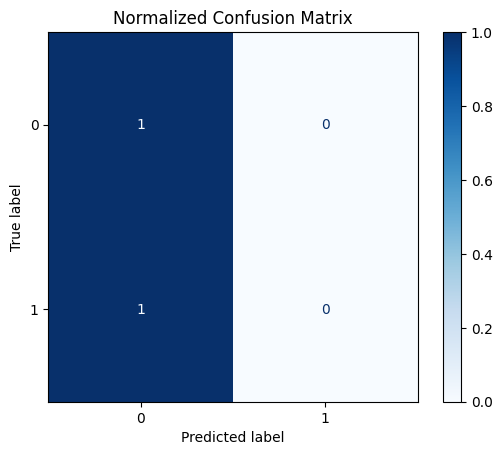

In [3]:
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)


# 4. Train Model
svm_clf.fit(X_train, y_train)

# 5. Predict on Test Set
y_pred = svm_clf.predict(X_test)

# 6. Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Plot Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    svm_clf, X_test, y_test, #display_labels=y_test.EditEff,
    cmap=plt.cm.Blues, normalize='true'
)
plt.title("Normalized Confusion Matrix")
plt.show(block=False)

y_prob = svm_clf.predict_proba(X_test)[:, 1]

# 5. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

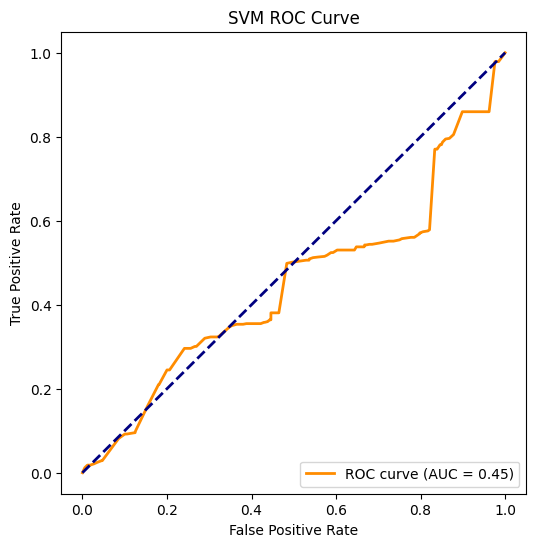

In [4]:
# 5. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [5]:
# Random forest classifier 
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"  # helps if data is imbalanced
)
rf.fit(X_train, y_train)

# 4. Get probability scores (for positive class)
y_probRF = rf.predict_proba(X_test)[:, 1]

# 5. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probRF)
roc_auc = auc(fpr, tpr)

# 6. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)


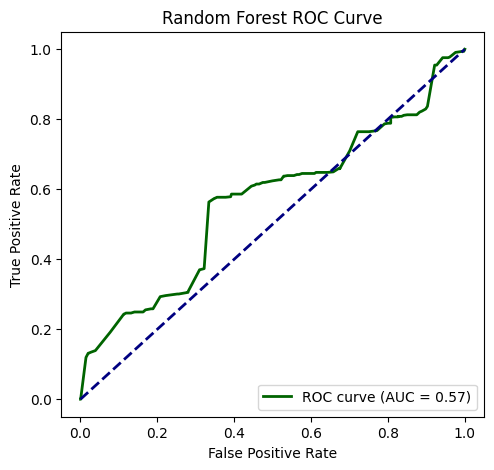

In [6]:
# 7. Plot ROC curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color="darkgreen", lw=2,
         label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")


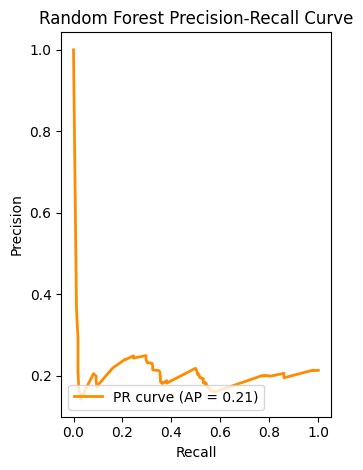

In [7]:
# 8. Plot Precision-Recall curve
plt.subplot(1,2,2)
plt.plot(recall, precision, color="darkorange", lw=2,
         label=f"PR curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()